In [ ]:
# 시계열 데이터 맛보기. 어렵다
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%203%20-%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
print(tf.__version__)


2.4.0


The next code block will set up the time series with seasonality, trend and a bit of noise. 

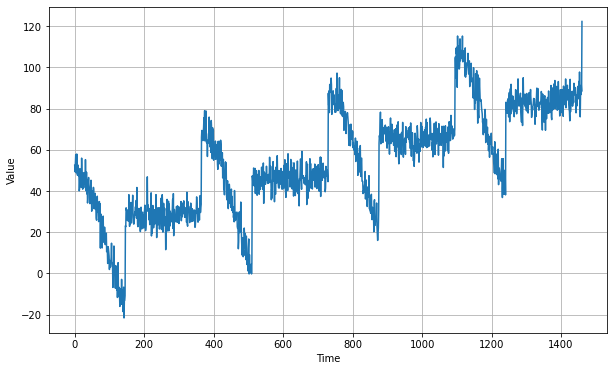

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32") # np.arange : 배열 나타내기. 1을 더한 이유는 맨 마지막 값 예측 유무 확인용
baseline = 10
series = trend(time, 0.1)  
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6)) # 그래프 사이즈
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

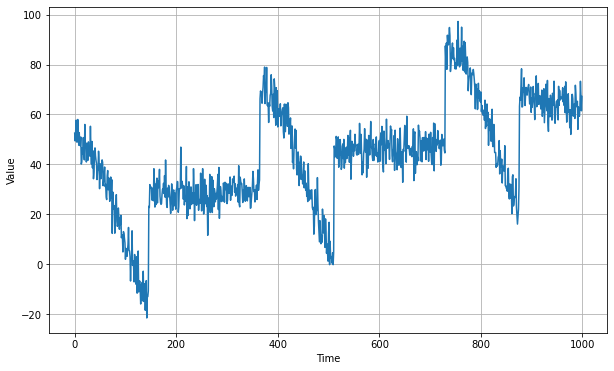

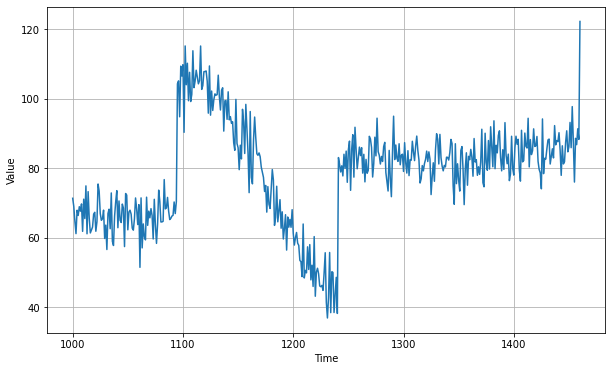

In [4]:
split_time = 1000 # 테스트셋, 검증셋으로 분리
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# 훈련셋, 검증셋 모두 seasonal 패턴이 적어도 하나는 들어있다는 것을 확인할 수 있다. 
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [7]:
# 마지막 그래프 모양이 미래에도 그대로 나타날 것이라 가정하고 예측하는거. 가장 간단한 방법
naive_forecast = series[split_time - 1:-1] # 검증셋인인데 시작점과 끝점이 앞으로 한칸씩 당겨진거

[ 67.19674   71.34472   68.98552   64.6752    61.15736   67.89844
  66.390305  68.91469   67.6307    69.71901   61.81174   71.091835
  65.51008   74.91588   61.11138   73.25516   65.58317   61.35506
  62.21152   63.048264  66.79013   67.30303   61.840164  64.60695
  75.460365  73.40727   66.971954  65.00137   65.43278   67.9217
  59.761875  63.610905  56.577053  66.938515  68.20101   62.571968
  72.88092   58.905464  57.73595   66.20383   70.34101   73.54933
  62.859653  70.57207   65.010925  64.36533   69.671974  68.5407
  57.42275   72.71323   72.256996  62.25493   67.38817   67.9059
  66.7659    62.737984  62.15856   65.41626   71.43522   68.31729
  63.774124  69.51377   51.440834  71.45582   57.042038  63.957195
  60.20002   59.354107  71.66096   63.547802  67.648476  65.71117
  68.36095   66.39001   59.62124   71.048     63.628506  58.345173
  64.01845   73.693924  70.47248   64.50952   64.538055  64.707886
  76.73166   68.2896    68.56229   71.59581   67.670784  65.21421
  65.560

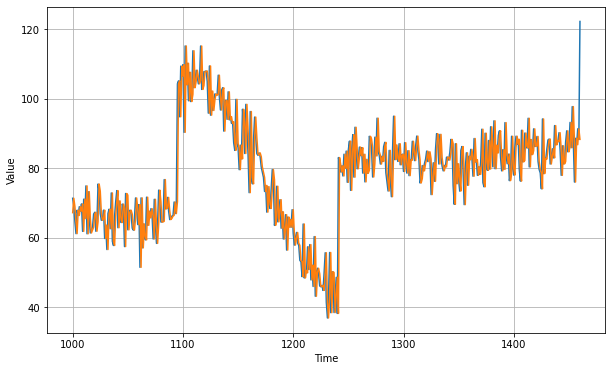

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

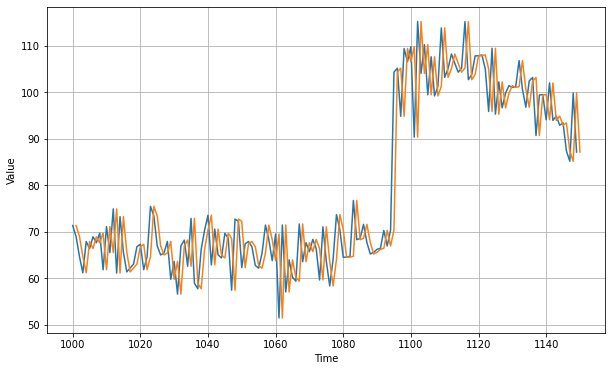

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151) #오른쪽으로 한칸 옮김

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [10]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) # mse : 오차의 제곱을 다 더하고 평균낸거
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) # mae : 차이를 절대값으로 만든 걸 다 더하고 평균낸거

61.827534
5.937908


That's our baseline, now let's try a moving average:

In [11]:
# moving average를 이용해 예측. moving average : 전체 데이터의 평균을 구하는게 아니라 일정 구간의 평균을 구하는데 구간이 계속 바뀜 -> 변하는 구간에서의 평균을 계속 구하면서 값을 예측하는거임
# 이전에 했던 naive 예측방식보다 더 그럴싸한 방식이긴 한데 데이터 부족이라 그런가 오차가 더 크다.
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean()) # 30일 구간 기준으로 평균 구한걸 forecast에 넣음
  return np.array(forecast)

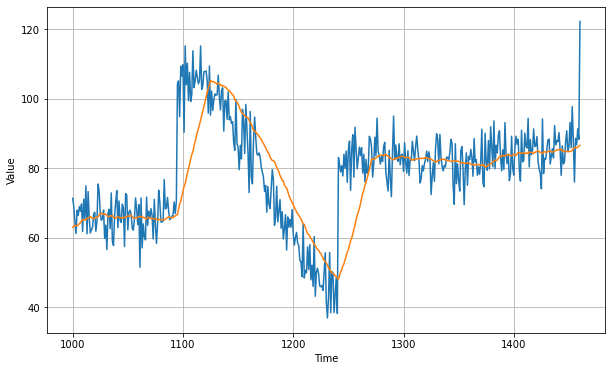

In [14]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:] # 30 time 전 데이터를 참고해 예측

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 실제값
plot_series(time_valid, moving_avg) # 예측값

In [15]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# 오차가 늘어났다. 

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

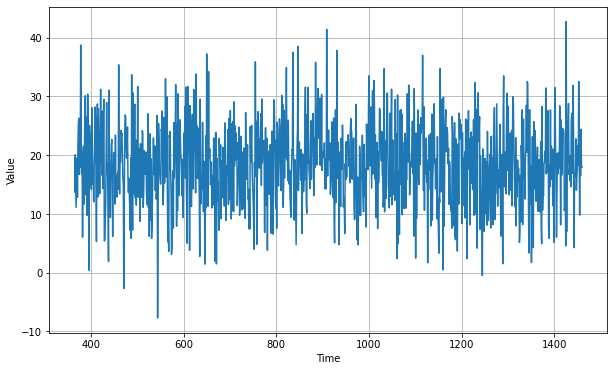

In [16]:
# 차이값을 이용해 예측. 이렇게 하면 그 일정 시간마다 특정 패턴 보이는걸 없앨 수 있다. 왜냐하면 그게 나타나는 주기가 365거든.
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

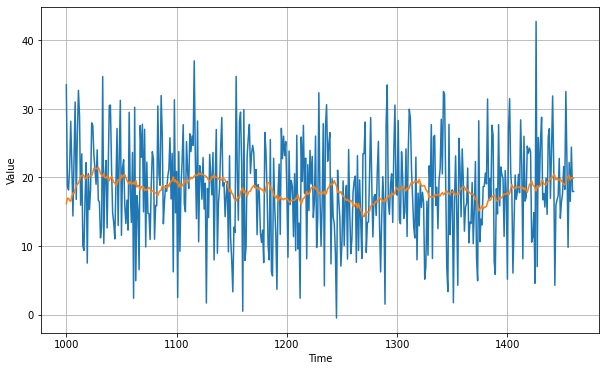

In [22]:
# 일정 패턴 제거 후 이동 평균 구하기.
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:] # 평균 구하는 구간만큼 뒤의 리스트에서 빼줘야한다. split_time - (평균 구하는 구간). 365를 뺀 이유는 패턴을 제거했기 때문.

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

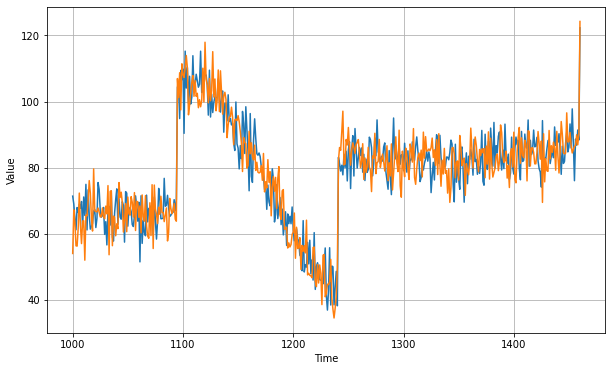

In [23]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg # 1년 전 데이터에 앞서 구한 이동 평균을 더해 1년 뒤 값을 예측한다

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 현재 값(검증 세트)
plot_series(time_valid, diff_moving_avg_plus_past) # 1년 전 데이터로 예측한 값
plt.show()

In [24]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()) # 오차가 ㅈ루었다

53.764584
5.9032416


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

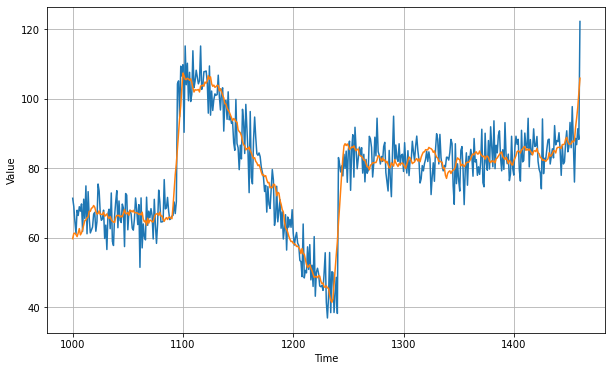

In [25]:
# 노이즈 제거한 과거 데이터에 이동 평균 더한 값으로 미래 예측 
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [27]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.885323
4.5876207
